<a href="https://colab.research.google.com/github/Deurru/DLND/blob/master/dlnd_face_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [118]:
# get remote-hosted zipfile

!test ! -e processed_celeba_small && wget -c https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip

# unzip file
!unzip -qq processed-celeba-small.zip

# Search for git repo and if not existing (! -e) clone it

!test ! -e deep-learning-v2-pytorch && git clone https://github.com/udacity/deep-learning-v2-pytorch.git

# Move project contents to /content, so they are accessible

!mv deep-learning-v2-pytorch/project-face-generation/* /content 

# remove unnecessary files, save space!
!test -e __MACOSX && rm -r __MACOSX*
!rm -r processed-celeba-small.zip
!rm -r deep-learning-v2-pytorch
# !rm -r README.md

unzip:  cannot find or open processed-celeba-small.zip, processed-celeba-small.zip.zip or processed-celeba-small.zip.ZIP.
Cloning into 'deep-learning-v2-pytorch'...
remote: Enumerating objects: 1078, done.
remote: Total 1078 (delta 0), reused 0 (delta 0), pack-reused 1078
Receiving objects: 100% (1078/1078), 138.73 MiB | 8.28 MiB/s, done.
Resolving deltas: 100% (466/466), done.
mv: cannot move 'deep-learning-v2-pytorch/project-face-generation/assets' to '/content/assets': Directory not empty
rm: cannot remove 'processed-celeba-small.zip': No such file or directory


In [0]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [0]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [0]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [0]:
def get_dataloader(batch_size, image_size, data_dir=data_dir):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    
    dataset = datasets.ImageFolder(data_dir, transform)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                            num_workers=0)
    
    return dataloader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [0]:
# Define function hyperparameters
# batch_size from DCGAN paper
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

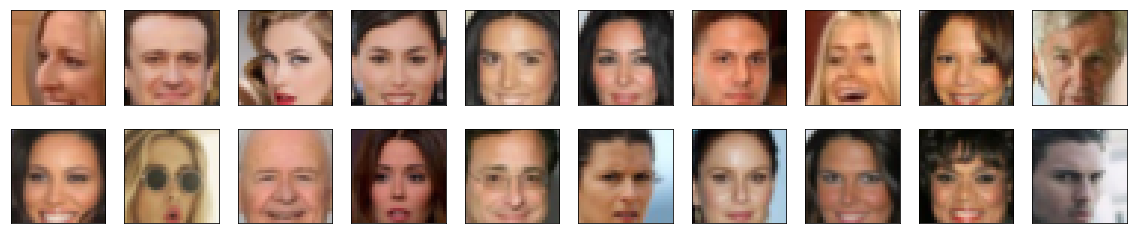

In [154]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [0]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    '''
    Scale takes in an image x and returns that image, scaled
    with a feature_range of pixel values from -1 to 1. 
    This function assumes that the input x is already scaled from 0-1.
    '''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [156]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8353)
Max:  tensor(0.8980)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates series of convolutional layers, with optional batch normalization.
    Best results with kernel_size=4 (so 4*4 filter)
    Spatial size output (downsampling of x-y dims) = ((W - F + 2P)/S) + 1
    W=input size; F=kernel size; P=padding;S=Stride
    """
    #Creates empty list to append the layers for input to Sequential container
    layers = []
    
    # Creates Conv Layer with params passed to function
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # Appends the Conv layer to list of layers
    layers.append(conv_layer)
    
    # If batch_norm=True, creates and appends batchnorm layer to list of layers
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    # "*" unpacks list of layers, in order.
    # Returns container with series of layers
    return nn.Sequential(*layers)

In [159]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        :Spatial size output (downsampling) = ((W - F + 2P)/S) + 1
         W=input size; F=kernel size; P=padding;S=Stride
        """
        super(Discriminator, self).__init__()

        # complete init function
        
        # Saves passed conv_dim parameter, for use through process
        self.conv_dim = conv_dim
        
        # In: n-dim x 3-channel img; Out dims/2 x conv_dim channels
        #(for 32x32x3, out is 16 x 16 x conv_dim)
        # First layer, so no batch_norm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        
        # In: conv_dim channel x 16 x 16; Out: conv_dim*2 x 8 x 8
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        
        # In: conv_dim*2 x 8 x 8; Out: conv_dim*4 x 4 x 4
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        # Final, fully-connected layer
        # In: flattened conv_dim*4 x 4 x 4 inputs; Out: 1 value
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        # 3 hidden layers with leaky ReLU, negative slope = 0.2
        out1 = F.leaky_relu(self.conv1(x), 0.2)
        out2 = F.leaky_relu(self.conv2(out1), 0.2)
        out3 = F.leaky_relu(self.conv3(out2), 0.2)
        
        # Flatten hidden layers output, for input to FC
        flatten = out3.view(-1, self.conv_dim*4*4*4)
        
        # Output layer returning discriminator logits
        x = self.fc(flatten)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [0]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1,
           batch_norm=True):
    """
    Creates series of transposed-convolutional layers,
    with optional batch normalization.
    Best results with kernel_size=4 (so 4*4 filter)
    Used to upsample x-y output of Discriminator until final GAN output
    """
    
    #Creates empty list to append the layers for input to Sequential container
    layers = []
    
    # Creates transposed-Conv Layer with params passed to function
    t_conv_layer = nn.ConvTranspose2d(in_channels, out_channels,
                                           kernel_size, stride, padding,
                                           bias=False)
    
    # Appends the Conv layer to list of layers
    layers.append(t_conv_layer)
    
    # If batch_norm=True, creates and appends batchnorm layer to list of layers
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
    
    # "*" unpacks list of layers, in order.
    # Returns container with series of layers
    return nn.Sequential(*layers)

In [161]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        # Saves passed conv_dim parameter, for use through process
        self.conv_dim = conv_dim
        
        # Fully-connected layer as entry to Generator
        # In: z inputs from latent vector; Out: conv_dim*4 x 4 x 4
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        # In: conv_dim*4 x 4 x 4; Out: conv_dim*2 x 8 x 8
        self.tconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        
        # In: conv_dim*2 x 8 x 8; Out: conv_dim channel x 16 x 16
        self.tconv2 = deconv(conv_dim*2, conv_dim, 4)
        # In: conv_dim channel x 16 x 16; Out: 32 x 32 x 3. No batch_norm.
        self.tconv3 = deconv(conv_dim, 3, 4, batch_norm=False)   

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        # Input through FC layer
        out1 = self.fc(x)
        
        # deflatten to conv format (batch_size, Depth, Width, Height)
        # -1 is a placeholder for appropriate auto batch_size
        deflat = out1.view(-1, self.conv_dim*4, 4, 4)
        
        # 3 hidden layers with deconv, upsampling x-y by factor 2, 
        # decreasing depth by 4 with each layer
        # Final output is 32x32x3 img
        out2 = F.relu(self.tconv1(deflat))
        out3 = F.relu(self.tconv2(out2))
        out4 = self.tconv3(out3)
        
        # Tanh function ensures pixel values range from -1 to 1
        x = torch.tanh(out4)
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [0]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Initializes weight of Convs and Linears 
    # to normal_(tensor, mean, std). Defaults: mean= 0.; std=1.
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or
                                 classname.find('Linear') != -1):
      
      nn.init.normal_(m.weight.data, 0, 0.02)

    
    # If bias, init to constant_(tensor, val)
    if hasattr(m, 'bias') and m.bias is not None:
      nn.init.constant_(m.bias.data, 0.0)
#       m.bias.data.fill_(0)
    
    
#     ********************** Different options for bias init
    
    
    
#     if hasattr(m, 'weight') and (classname.find('Conv') != -1 or
#                                  classname.find('Linear') != -1):
      
#       nn.init.normal_(m.weight.data, 0, 0.02)
      
#       # If bias, init to constant_(tensor, val)
#       if hasattr(m, 'bias') and m.bias is not None:
#         m.bias.data.fill_(0)
# #         nn.init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [164]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
#input of generator, i.e. size of the latent vector
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (tconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [165]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [0]:
def real_loss(D_out):
    '''
    Calculates how close discriminator outputs are to being real.
    params:
    :D_out: logits output by discriminator
    :return: real loss
    '''
    # Gets nr of values in Discriminator outputs
    batch_size = D_out.size(0)
    
    # Create ground-truth real labels. Instead of =1, uses =0.9 "smooth"
    # labels, to improve generalization and make training stable 
    # (batch_size-labels, all 0.9)
    labels = torch.ones(batch_size)*0.9
    
    # Moves labels to GPU if training there
    if train_on_gpu:
        labels = labels.cuda()
    
    # defines numerically-stable criterion. Binary Cross-Entropy Loss
    # applies sigmoid function to Disc. logits
    criterion = nn.BCEWithLogitsLoss()
    
    # Passes function input (with empty dims squeezed) 
    #and labels to criterion
    loss = criterion(D_out.squeeze(), labels)
    
    return loss
  
def fake_loss(D_out):
    '''
    Calculates how close discriminator outputs are to being fake.
    param, D_out: discriminator logits
    return: fake loss
    '''
    batch_size = D_out.size(0)
    # Creates ground-truth fake labels (=0)
    #(batch_size-labels, all 0)
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
     
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [0]:
import torch.optim as optim

# Parameters extracted from the original DCGAN paper 
# at https://arxiv.org/pdf/1511.06434.pdf

lr=0.0002 # The usual 0.001 is too high
beta1=0.2 # The original 0.9 made training unstable
beta2=0.999 # Default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [0]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # zeroes-out any accumulated gradients
            d_optimizer.zero_grad()
            
            
            # 1. Train the discriminator on real and fake images
            
            # Training on REAL images
            
            # Move images to GPU
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # Trains the DISCRIMINATOR on real images
            disc_real = D(real_images)
            # ccomputes loss on real images
            disc_real_loss = real_loss(disc_real)
            
            # Training on FAKE images
            
            # Generate fake images
            # Creates latent vector of batch_size random uniform values
            #between -1 and 1
            lat_vect = np.random.uniform(-1, 1, size=(batch_size, z_size))
            lat_vect = torch.from_numpy(lat_vect).float()
            
            # moves vector to GPU
            if train_on_gpu:
                lat_vect = lat_vect.cuda()
            # Passes vector to generator, output is fake images
            fake_images = G(lat_vect)
            
            # Trains the discriminator on fake images
            disc_fake = D(fake_images)
            # ccomputes loss on fake images
            disc_fake_loss = fake_loss(disc_fake)
            
            # compute total loss and perform backprop
            disc_total_loss = disc_real_loss + disc_fake_loss
            disc_total_loss.backward()
            d_optimizer.step()
            
            # 2. Train the GENERATOR with an adversarial loss
            
            # zeroes-out any accumulated gradients
            g_optimizer.zero_grad()
            
            # Generate fake images
            lat_vect = np.random.uniform(-1, 1, size=(batch_size, z_size))
            lat_vect = torch.from_numpy(lat_vect).float()
            if train_on_gpu:
                lat_vect = lat_vect.cuda()
            fake_images = G(lat_vect)
            
            # Use real_loss function to flip labels
            # pass fake imgs to gest disc outputs
            D_fake = D(fake_images)
            
            # Calculates adversarial loss by passing disc outputs to real_loss
            # and getting how much are they close to being real (i.e. 1)
            gen_loss = real_loss(D_fake)
            
            # Perform backprop
            gen_loss.backward()
            g_optimizer.step()
                       
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((disc_total_loss.item(), gen_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, disc_total_loss.item(), gen_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [169]:
# set number of epochs (at least 40 are recommended)
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.6299 | g_loss: 1.6752
Epoch [    1/   50] | d_loss: 1.4601 | g_loss: 1.2362
Epoch [    1/   50] | d_loss: 0.8282 | g_loss: 2.5294
Epoch [    1/   50] | d_loss: 0.8281 | g_loss: 1.1962
Epoch [    1/   50] | d_loss: 0.7823 | g_loss: 2.3751
Epoch [    1/   50] | d_loss: 0.9356 | g_loss: 1.2781
Epoch [    1/   50] | d_loss: 1.2354 | g_loss: 2.0431
Epoch [    1/   50] | d_loss: 1.3753 | g_loss: 2.4242
Epoch [    1/   50] | d_loss: 1.0622 | g_loss: 1.4672
Epoch [    1/   50] | d_loss: 1.9762 | g_loss: 0.4246
Epoch [    1/   50] | d_loss: 1.1563 | g_loss: 1.4509
Epoch [    1/   50] | d_loss: 1.2711 | g_loss: 0.7430
Epoch [    1/   50] | d_loss: 1.0398 | g_loss: 1.1578
Epoch [    1/   50] | d_loss: 1.0629 | g_loss: 1.2107
Epoch [    1/   50] | d_loss: 1.1247 | g_loss: 1.6226
Epoch [    2/   50] | d_loss: 1.0449 | g_loss: 1.1207
Epoch [    2/   50] | d_loss: 1.0469 | g_loss: 1.0163
Epoch [    2/   50] | d_loss: 1.1552 | g_loss: 0.7741
Epoch [    2/   50] | d_loss

In [0]:
# Tracking results

# 1.lr = 0.0002; 50 eps; smooth=True; bias_init=constant 0.0, indent;
# Train time 40.4 mins (0.8mins/ep); Loss = d_loss: 0.4624 | g_loss: 3.3449

# 2.lr = 0.0002; 50 eps; smooth=False; bias_init=constant 0.0, indent;
# Train time 40.0 mins (0.8mins/ep); Loss = d_loss: 0.1971 | g_loss: 2.7291
# Comment: worse result on image output

# 3.lr = 0.0002; 50 eps; smooth=False; bias_init=fill_(0), indent;
# Train time 39.8 mins (0.79mins/ep); Loss = d_loss: 0.1655 | g_loss: 2.1374
# Comment: worse result on image output

# 4.lr = 0.0002; 50 eps; smooth=False; bias_init=fill_(0), no indent;
# Train time  41.6mins (0.8mins/ep); Loss = d_loss: 0.2723 | g_loss: 3.6363
# Comment:

# 5.lr = 0.0002; 50 eps; smooth=True; bias_init=fill_(0), no indent;
# Train time  41.6mins (0.8mins/ep); Loss = d_loss: 0.5245 | g_loss: 2.1717
# Comment: worse result on img output, slightly more stable training graph

# 6.lr = 0.0002; 50 eps; smooth=True; bias_init=constant 0.0, no indent;
# Train time  40.9mins (0.6mins/ep); Loss = d_loss: 0.4684 | g_loss: 2.7637
# Comment: 

# Until here, G&D dims =  32, z_size=100

# 7.lr = 0.0002; 50 eps; smooth=True; bias_init=constant 0.0, no indent;
# g_dim=64, d_dim=64; z_size=100;
# Train time  mins (mins/ep); Loss = d_loss: 
# Comment: data not noted. Imaage output fine, chart not so good (?) REPEAT

# Until here, only Resize and ToTensor transforms

# 8.lr = 0.0002; 50 eps; smooth=True; bias_init=constant 0.0, no indent;
# g_dim=64, d_dim=64; z_size=100
# Transforms: +CenterCrop
# Train time  48.4mins (0.96mins/ep); Loss = d_loss: 0.4551 | g_loss: 3.8745
# Comment: Not so bad img output, chart not so good.

#  Until here, beta1 = 0.5

# 9.lr = 0.0002; 50 eps; smooth=True; bias_init=constant 0.0, no indent;
# g_dim=128, d_dim=128; z_size=100; beta1 = 0.2
# Transforms: No CenterCrop
# Train time  mins (mins/ep); Loss = 
# Comment: 

# check weight init.

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

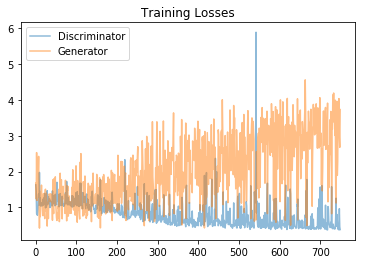

In [170]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [0]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

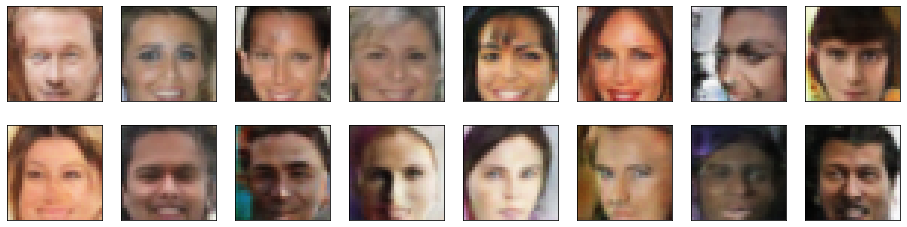

In [173]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

Longer training

Bigger, more dense model

Different weight initializers

Different optimizers (SGD), and different combination of them (same on both, combining SGD&ADAM on each)

Bigger dataset, more diverse in terms of race, gender and age.

64*64 images

Problems: low res, problems with shadows

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.